# Introduction:

Multivariate time series analysis is a statistical technique that analyses multiple time series data sets to identify patterns and relationships between them. This can be used to forecast future values of the time series, identify causal relationships between them, or simply gain a better understanding of how they interact.

Multivariate time series analysis is often used in finance, economics, and other fields where it is important to understand how multiple variables are related to each other. For example, a financial analyst might use multivariate time series analysis to forecast the future price of a stock based on the past prices of other stocks, economic indicators, or news events.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, GRU #can train using either GRU or LSTM

from sklearn.preprocessing import StandardScaler

In [11]:
df = pd.read_csv('HON.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-21,143.211502,144.850449,142.828110,144.237030,128.132599,2553500
1,2018-05-22,144.840866,146.125183,144.246628,144.601242,128.456177,3493247
2,2018-05-23,143.767395,145.118805,143.585297,145.032547,128.839325,2952060
3,2018-05-24,145.137985,145.990997,143.575699,144.802521,128.634995,2753615
4,2018-05-25,144.543747,145.233826,143.575699,144.399979,128.277374,2018260


In [12]:
# convert the Date column to DateTime from Object type
train_set_dates = pd.to_datetime(df['Date'])
train_set_dates.head()

# extract the required features (in this we are omiting the volume from feature list)
columns = list(df.columns[1:6])
print(columns)

df_train = df[columns].astype(float)
df_train.head()

# Normalize the data using the Standard scaler
standard_scaler = StandardScaler()
scalar = standard_scaler.fit(df_train)
scaled_training_df = scalar.transform(df_train)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [13]:
trainX = []
trainY = []

future_no_of_days = 1 # num of days to predict the future values
past_no_of_days = 14 # number of days on which the prediction is computed

for i in range(past_no_of_days, len(scaled_training_df) - future_no_of_days+1):
    trainX.append(scaled_training_df[i - past_no_of_days:i, 0:df_train.shape[1]])
    trainY.append(scaled_training_df[i + future_no_of_days - 1:i + future_no_of_days, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape: {}'.format(trainX.shape))
print('trainY shape: {}'.format(trainY.shape))

trainX shape: (1245, 14, 5)
trainY shape: (1245, 1)


In [14]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 14, 64)            13632     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23073 (90.13 KB)
Trainable params: 23073 (90.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.2303 - val_loss: 0.0148
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0574 - val_loss: 0.0090
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0069
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0403 - val_loss: 0.0075
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0046
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0042
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0046
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0055
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0051
Epoch 10/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.0084
Epoch 11/

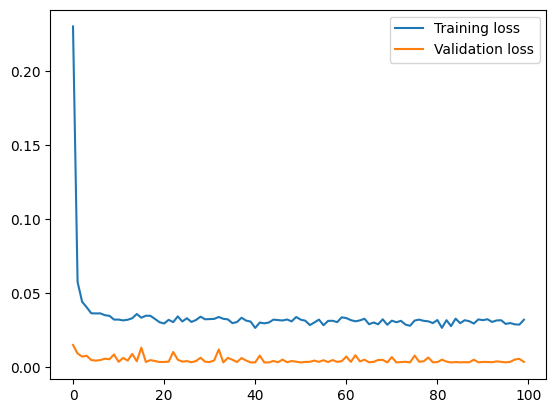

In [15]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 90
n_days_for_prediction=90  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_set_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist() # instead of us_bd we can give '1d' etc.

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

# predict the future price
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-1-1'] # selecting the data only from 2022 just for our convinence

3/3 [==============================] - 0s 2ms/step


/var/folders/bx/s_yjy4jn1536vj6cptf3nsr40000gn/T/ipykernel_4680/4018031034.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


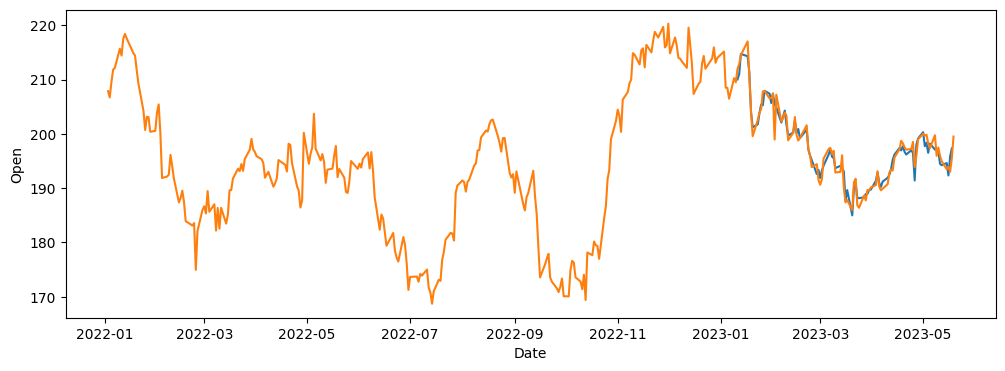

In [17]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_forecast, x='Date', y='Open', )
sns.lineplot(data=original, x='Date', y='Open')
plt.show()

# Conclusion:

In summary, multivariate time series analysis using LSTM and GRU models is a powerful approach for modeling and predicting complex temporal relationships in data. These deep learning models excel at capturing long-term dependencies and can leverage multiple variables to improve prediction accuracy. By incorporating interactions and relationships between variables, they provide comprehensive and accurate forecasting. However, success relies on proper data preprocessing, feature selection, and model tuning, along with sufficient data and appropriate hyperparameter selection. Overall, multivariate time series analysis with LSTM and GRU models offers a valuable framework for forecasting and understanding complex temporal relationships in various domains.

This notebook is taken from [Medium.com](https://medium.com/aimonks/multivariate-timeseries-analysis-using-tensorflow-9554e607077a)